In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
# example of rotate shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from glob import glob
import cv2
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
!pip install tensorflow-addons
import random

import tensorflow_addons as tfa

     |████████████████████████████████| 679 kB 4.9 MB/s 


In [ ]:
# Image size that we are going to use
IMG_SIZE = 512
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 3

In [ ]:
!unzip "/content/mdxtraincrop.zip"

In [ ]:
import glob
from sklearn import model_selection
files=glob.glob('/content/cropped/images/*.png') #read in the files


In [ ]:
def rotate_im(image, angle):
    """Rotate the image.
    
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    
    Parameters
    ----------
    
    image : numpy.ndarray
        numpy image
    
    angle : float
        angle by which the image is to be rotated
    
    Returns
    -------
    
    numpy.ndarray
        Rotated Image
    
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

In [ ]:
def zoom(image, mask):
  # convert to numpy array
  data_img = img_to_array(image)
  data_msk = img_to_array(mask)

  # expand dimension to one sample
  samples_img = expand_dims(data_img, 0)
  samples_msk = expand_dims(data_msk, 0)
  samples = np.concatenate([samples_img, samples_msk], axis=3)

  # create image data augmentation generator
  datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
  it = datagen.flow(samples, batch_size=1)
  image2 = image
  while((image == image2).all()):
    batch = it.next()
    image2 = batch[0][:,:,0:3].astype('uint8')
    mask2 = batch[0][:,:,3:6].astype('uint8')
  return image2, mask2

def verflip(image, mask):
  # convert to numpy array
  data_img = img_to_array(image)
  data_msk = img_to_array(mask)

  # expand dimension to one sample
  samples_img = expand_dims(data_img, 0)
  samples_msk = expand_dims(data_msk, 0)
  samples = np.concatenate([samples_img, samples_msk], axis=3)

  # create image data augmentation generator
  datagen = ImageDataGenerator(vertical_flip=True)
  it = datagen.flow(samples, batch_size=1)
  image2 = image
  while((image == image2).all()):
    batch = it.next()
    image2 = batch[0][:,:,0:3].astype('uint8')
    mask2 = batch[0][:,:,3:6].astype('uint8')
  return image2, mask2

def rotate(image, mask):

  
  k = random.randint(1,3)
  image2 = rotate_im(image,90 * k).astype('uint8')
  mask2 = rotate_im(mask,90 * k).astype('uint8')


  return image2, mask2



"""
def rotate(image, mask):
  # convert to numpy array
  data_img = img_to_array(image)
  data_msk = img_to_array(mask)

  # expand dimension to one sample
  samples_img = expand_dims(data_img, 0)
  samples_msk = expand_dims(data_msk, 0)
  samples = np.concatenate([samples_img, samples_msk], axis=3)

  # create image data augmentation generator
  datagen = ImageDataGenerator(rotation_range=30)
  it = datagen.flow(samples, batch_size=1)
  image2 = image
  while((image == image2).all()):
    batch = it.next()
    image2 = batch[0][:,:,0:3].astype('uint8')
    mask2 = batch[0][:,:,3:6].astype('uint8')
  return image2, mask2
"""

"\ndef rotate(image, mask):\n  # convert to numpy array\n  data_img = img_to_array(image)\n  data_msk = img_to_array(mask)\n\n  # expand dimension to one sample\n  samples_img = expand_dims(data_img, 0)\n  samples_msk = expand_dims(data_msk, 0)\n  samples = np.concatenate([samples_img, samples_msk], axis=3)\n\n  # create image data augmentation generator\n  datagen = ImageDataGenerator(rotation_range=30)\n  it = datagen.flow(samples, batch_size=1)\n  image2 = image\n  while((image == image2).all()):\n    batch = it.next()\n    image2 = batch[0][:,:,0:3].astype('uint8')\n    mask2 = batch[0][:,:,3:6].astype('uint8')\n  return image2, mask2\n"

In [ ]:
for item in files:
  print(item)
  image = cv2.imread(item)
  mask = cv2.imread("/content/cropped/masks/"+os.path.basename(item))

  image1, mask1 = zoom(image,mask)
  cv2.imwrite("/content/cropped/images/"+os.path.basename(item).replace(".png","_zoom.png"),image1)
  cv2.imwrite("/content/cropped/masks/"+os.path.basename(item).replace(".png","_zoom.png"),mask1)

  image2, mask2 = verflip(image,mask)
  cv2.imwrite("/content/cropped/images/"+os.path.basename(item).replace(".png","_flip.png"),image2)
  cv2.imwrite("/content/cropped/masks/"+os.path.basename(item).replace(".png","_flip.png"),mask2)

  image3, mask3 = rotate(image,mask)
  cv2.imwrite("/content/cropped/images/"+os.path.basename(item).replace(".png","_rotate.png"),image3)
  cv2.imwrite("/content/cropped/masks/"+os.path.basename(item).replace(".png","_rotate.png"),mask3)



In [ ]:
files=glob.glob('/content/cropped/images/*.png') #read in the files

test_set_size = 0.2
#create training and validation stages and split the files appropriately between them
phases={}

phases["train"],phases["val"]=next(iter(model_selection.ShuffleSplit(n_splits=5,test_size=test_set_size).split(files)))


In [ ]:
os.makedirs('/content/train/images')
os.makedirs('/content/train/labels')
os.makedirs('/content/val/images')
os.makedirs('/content/val/labels')



In [ ]:
train_files = []
val_files = []

for i in range(len(phases["train"])):
    train_files.append(files[phases["train"][i]])
for i in range(len(phases["val"])):
    val_files.append(files[phases["val"][i]])


In [ ]:
#use to delete directories if needed
"""
import shutil

shutil.rmtree('/content/val/')
shutil.rmtree('/content/train/')
#shutil.rmtree('/content/mdxtraincrop/')
"""

In [ ]:

TRAINSET_SIZE = len(train_files)
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(val_files)
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 486 images.
The Validation Dataset contains 122 images.


In [ ]:

for item in train_files:
  print(item)
  image = cv2.imread(item)
  mask = cv2.imread("/content/cropped/masks/"+os.path.basename(item))
  cv2.imwrite("/content/train/images/"+os.path.basename(item),image)
  cv2.imwrite("/content/train/labels/"+os.path.basename(item),mask)
for item in val_files:
  print(item)
  image = cv2.imread(item)
  mask = cv2.imread("/content/cropped/masks/"+os.path.basename(item))
  cv2.imwrite("/content/val/images/"+os.path.basename(item),image)
  cv2.imwrite("/content/val/labels/"+os.path.basename(item),mask)

In [ ]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    imgpath = img_path
    image = tf.io.read_file(imgpath)
    image = tf.image.decode_png(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    mskpath = tf.strings.regex_replace(img_path, "images", "labels")
    mask = tf.io.read_file(mskpath)
    mask = tf.image.decode_png(mask, channels = 1)
    #background = class 0
    mask = tf.where(mask == 0, np.dtype('uint8').type(0), mask) #background  = class 0
    mask = tf.where(mask == 178, np.dtype('uint8').type(1), mask) #inside cell = class 1
    mask = tf.where(mask > 2, np.dtype('uint8').type(2), mask) #boundary = class 2




    return {'image': image, 'segmentation_mask': mask}

In [ ]:
import tensorflow_addons as tfa

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
SEED = 42
dataset_path = "/content"
training_data= "/train/images/"

val_data= "/val/images/"

train_dataset = tf.data.Dataset.list_files(dataset_path+training_data+"*.png", seed = SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path+val_data+"*.png", seed = SEED)
val_dataset = val_dataset.map(parse_image)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 3

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 50

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>


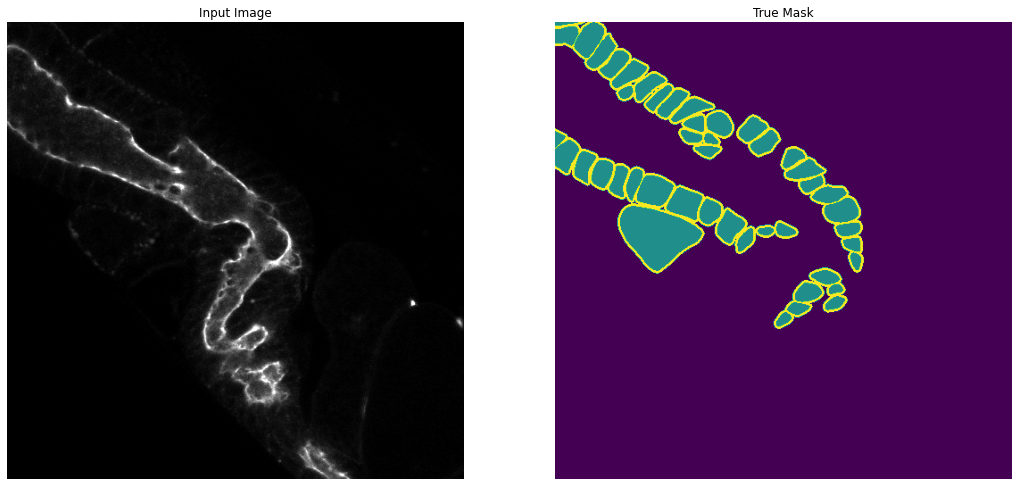

In [ ]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [ ]:
import os
import tempfile

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
output_chan = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False)
base_model = add_regularization(base_model, regularizer=tf.keras.regularizers.l2(0.01))

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 256x256
    'block_3_expand_relu',   # 128x128
    'block_6_expand_relu',   # 64x64
    'block_13_expand_relu',  # 32x32
    'block_16_project',      # 16x16
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
down_stack.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git


    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128
  x = last(x)

  #additional layer conv (1 or 2)
  """
  fin = tf.keras.layers.Conv2D(
      output_channels, 3, strides=1,
      padding='same')  #64x64 -> 128x128
  x = fin(x)

  fin = tf.keras.layers.Conv2D(
      output_channels, 3, strides=1,
      padding='same')  #64x64 -> 128x128
  x = fin(x)
  """
  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(output_chan)
#sgd = tf.keras.optimizers.SGD(nesterov=True, name="SGD")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_7 (Functional)            [(None, 256, 256, 96 1841984     input_9[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 32, 32, 512)  1476608     model_7[0][4]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 32, 32, 1088) 0           sequential_8[0][0]               
                                                                 model_7[0][3]              

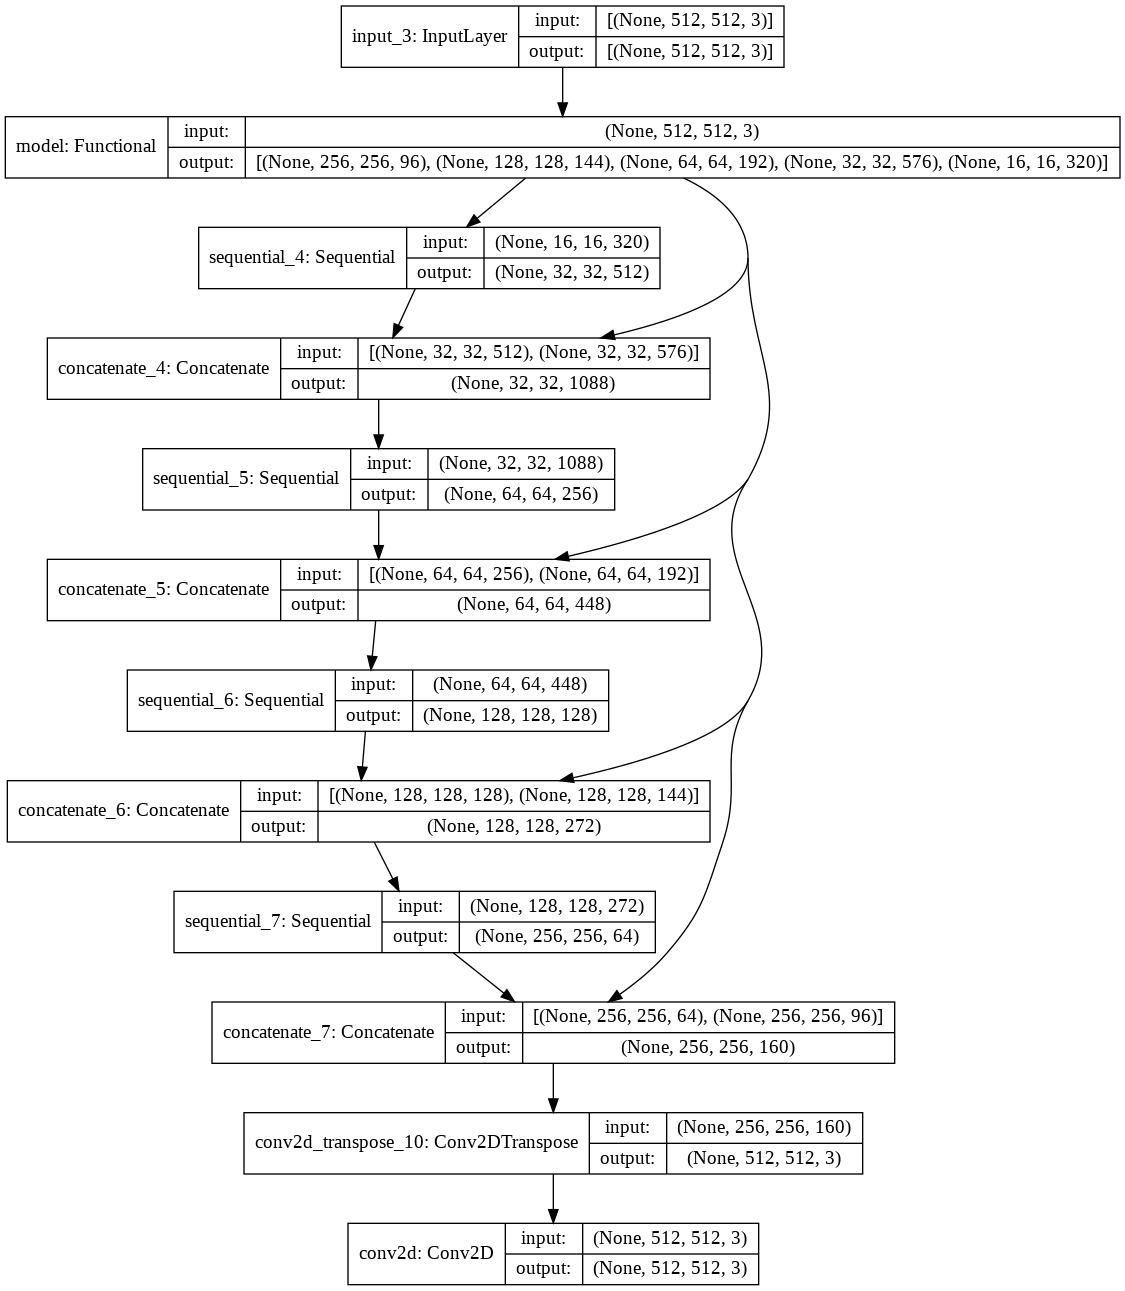

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)



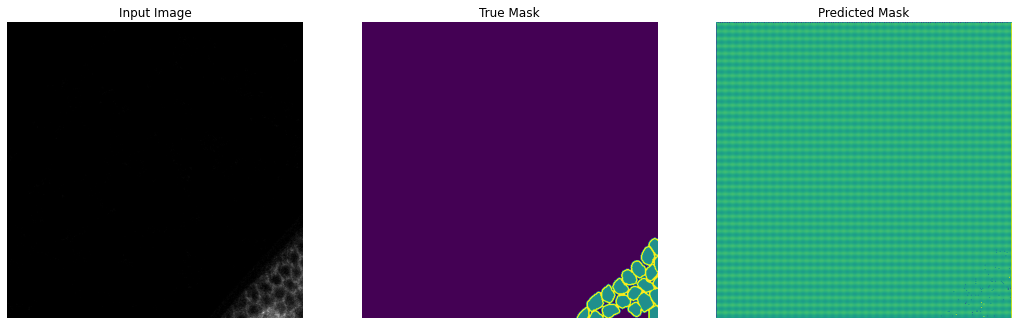

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            one_img_batch = image[0][tf.newaxis, ...]
            # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
            inference = model.predict(one_img_batch)
            # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
            pred_mask = create_mask(inference)
            # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
            display_sample([image[0], mask[0],
                            pred_mask[0]])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])


show_predictions()

In [ ]:
def add_sample_weights(image, label):

  class_weights = tf.constant([1.0, 2.0, 2.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)


  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

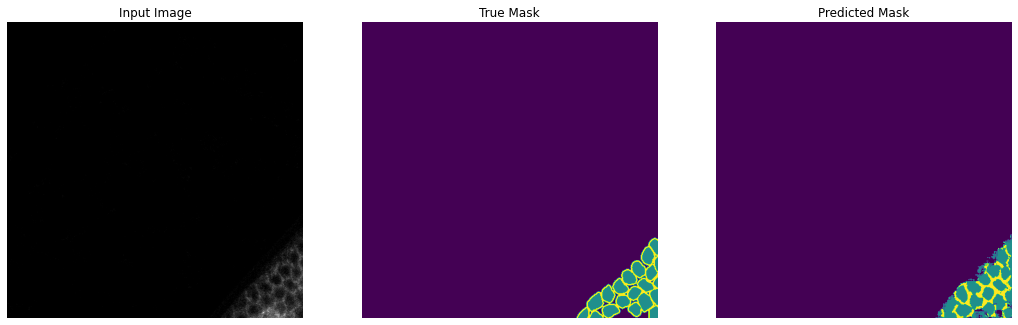


Sample Prediction after epoch 47


Epoch 00047: val_loss did not improve from 38.26478
Epoch 00047: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/814lessreg/assets


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
EPOCHS = 100
# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/814lessreg.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


model_history = model.fit(dataset['train'].map(add_sample_weights), epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks = callbacks)
model.save('/content/gdrive/MyDrive/814lessreg')

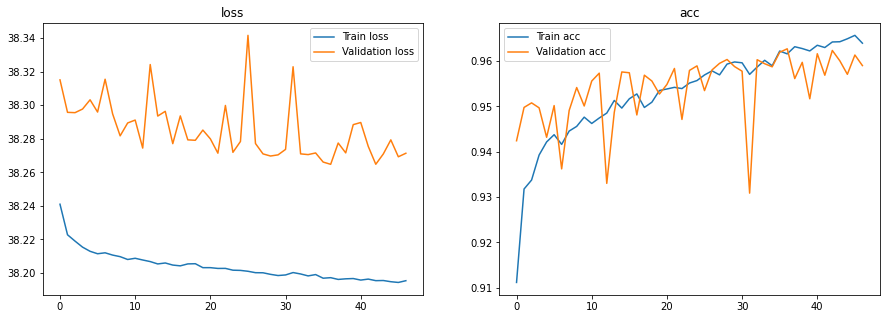

In [ ]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
show_final_history(model_history)


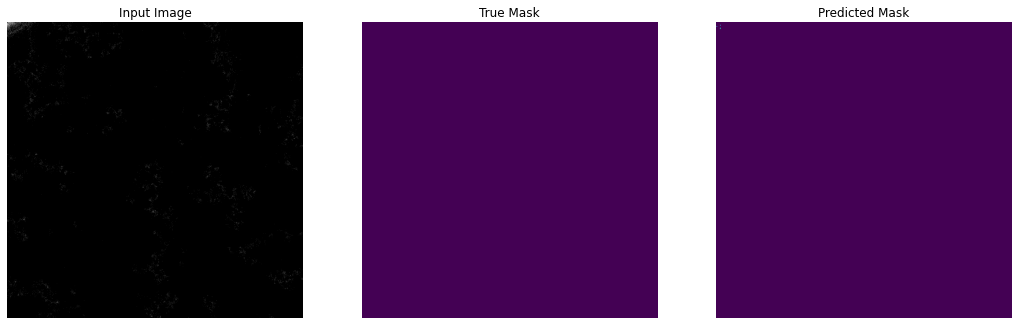

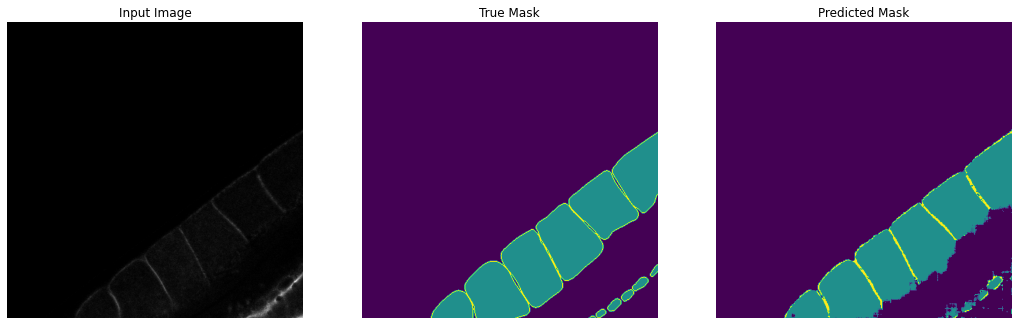

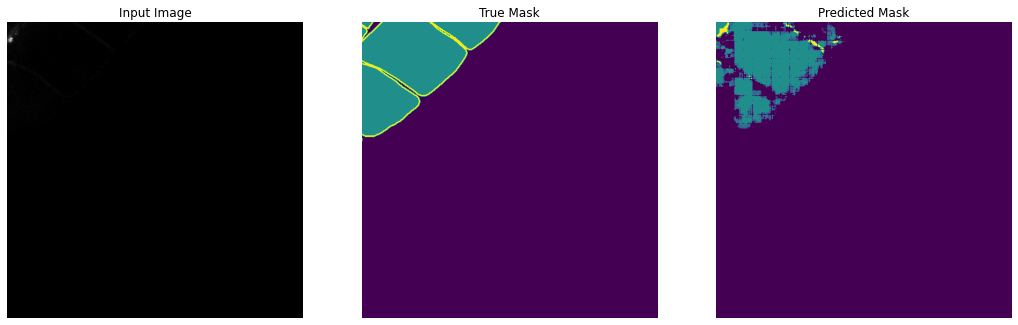

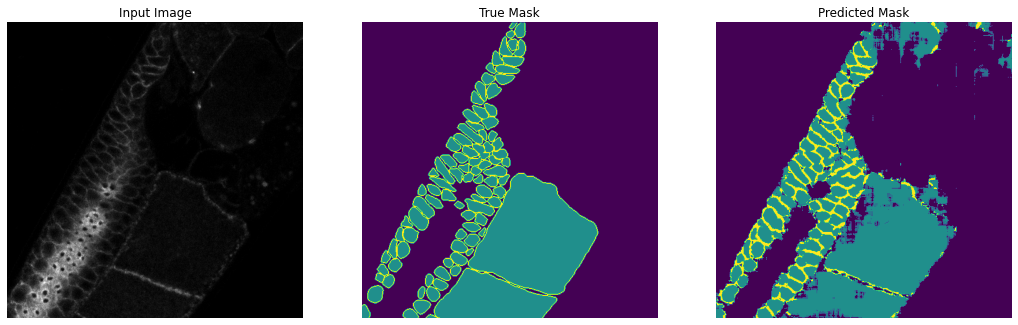

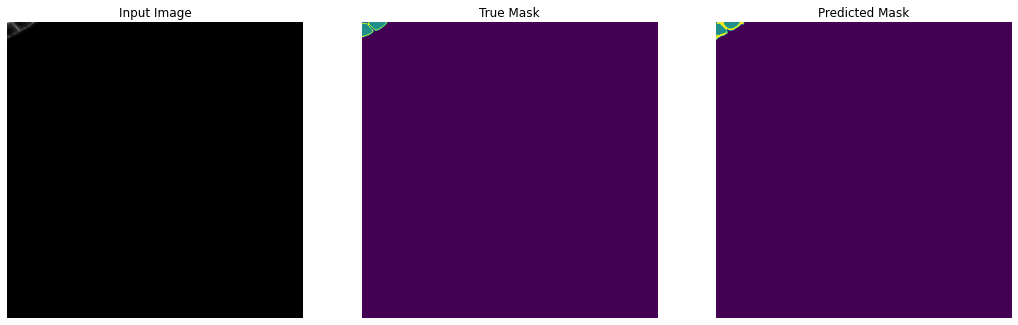

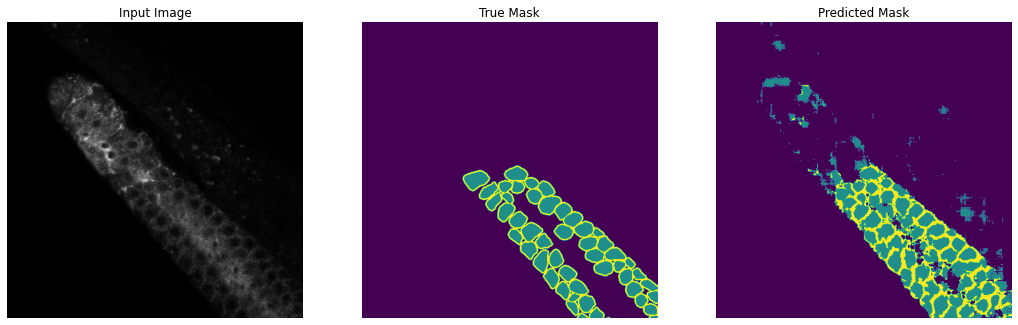

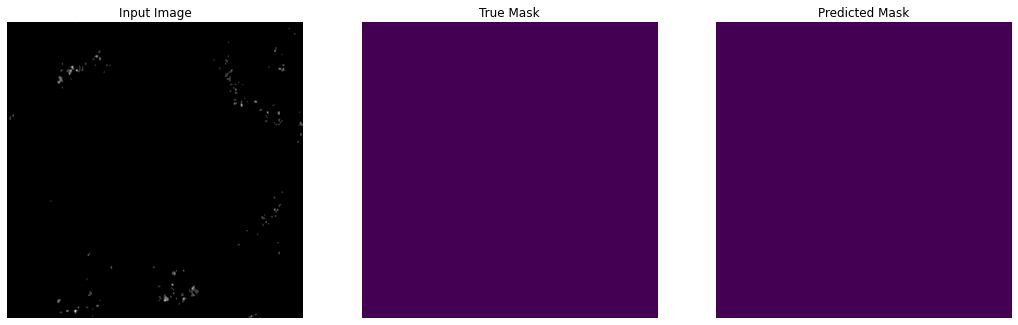

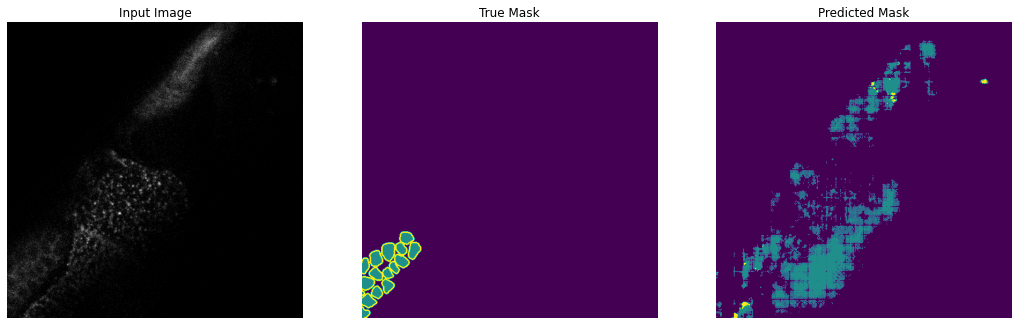

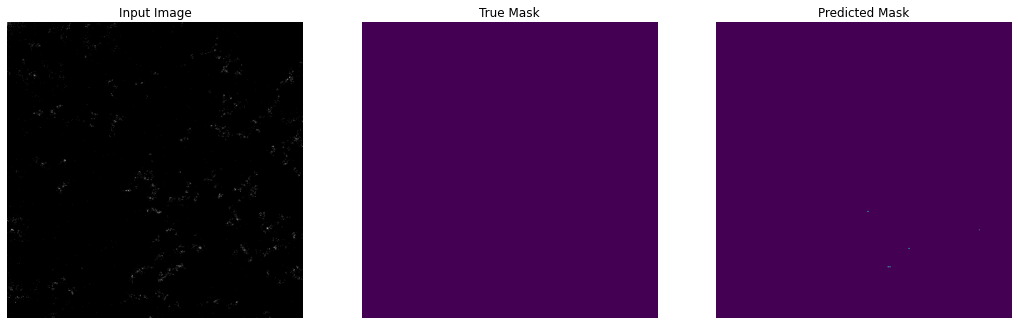

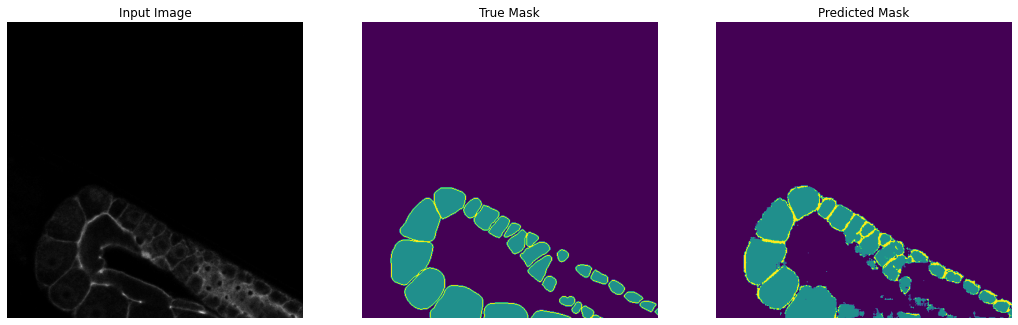

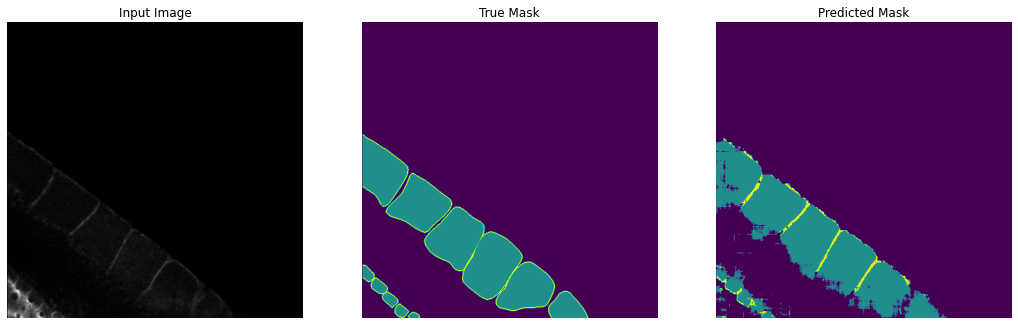

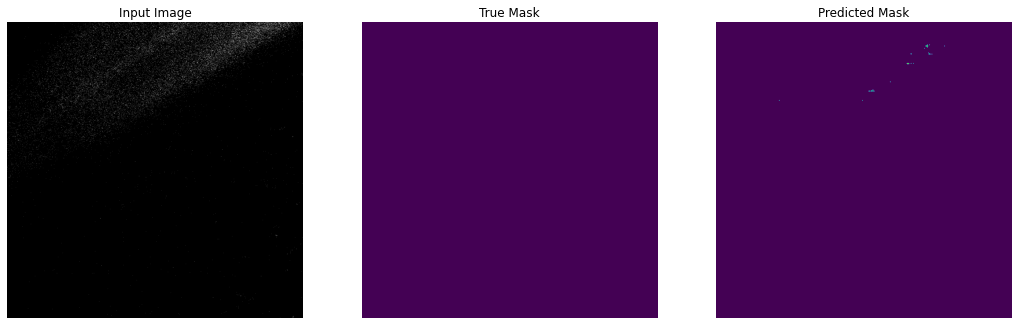

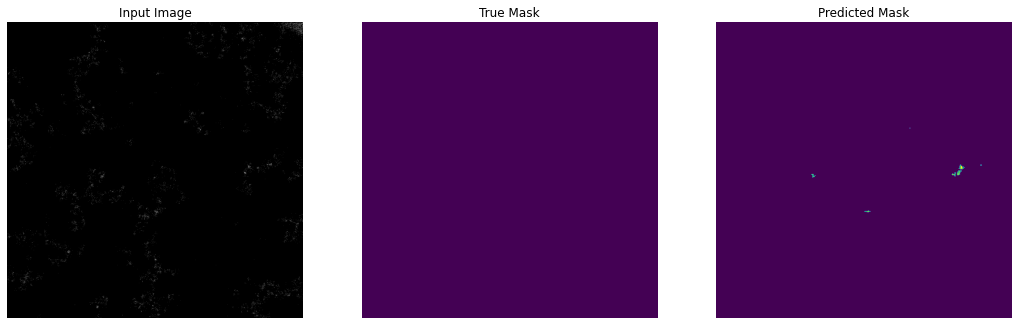

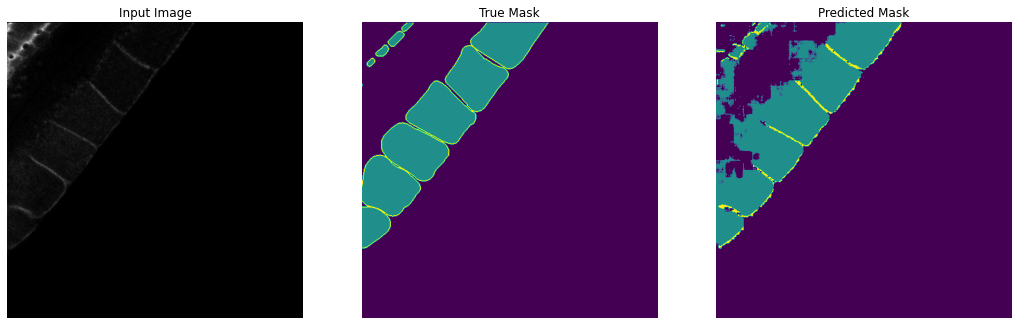

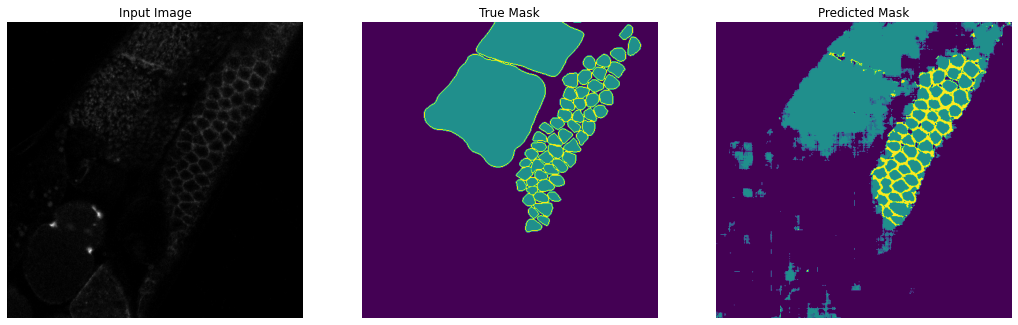

In [ ]:
#generate prediction from validation set
#model = weighted_model
#model.load_weights("/content/gdrive/MyDrive/weighedbest_model_unet.h5")
show_predictions(dataset['val'], 15 )

In [ ]:
#model = tf.keras.models.load_model('/content/gdrive/MyDrive/85smalll2')

In [ ]:
#fine tuning the conv base 
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
sgd = tf.keras.optimizers.SGD(nesterov=True, name="SGD")

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
len(model.trainable_variables)


Number of layers in the base model:  154


14

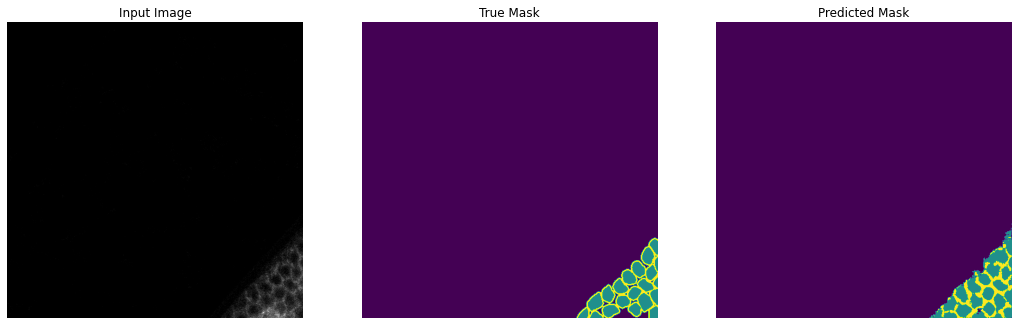


Sample Prediction after epoch 71


Epoch 00071: val_loss did not improve from 38.26478
Epoch 00071: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/814ft/assets


In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 2.0, 2.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights


fine_tune_epochs = 30
total_epochs =  47 + fine_tune_epochs

model_history = model.fit(dataset['train'].map(add_sample_weights), epochs=total_epochs,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          initial_epoch=model_history.epoch[-1],
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks = callbacks)
model.save('/content/gdrive/MyDrive/814ft')




In [ ]:
#postprocessing and stitching back the tiles together

import numpy as np
from keras.preprocessing import image
from PIL import Image
import numpy as np
from skimage import transform
#model = unet_model(output_chan)
#model = tf.keras.models.load_model('/content/gdrive/MyDrive/811ft3')
#model.load_weights("/content/gdrive/MyDrive/615best_model_unet.h5")
alpha = 3 # Contrast control (1.0-3.0)
beta = 70 # Brightness control (0-100)

for i in range(0,26):
  if (i<10):
    i = '0'+str(i)

  # Show the model architecture
  np_image1 = Image.open('/content/crop/2.0'+ str(i) + '_0_0.png')    
  np_image = np.array(np_image1).astype('float32')/255
  np_image = np.expand_dims(np_image, axis=0)
  pred = create_mask(model.predict(np_image))
  msk1 = tf.keras.preprocessing.image.array_to_img(pred[0])

  np_image2 = Image.open('/content/crop/2.0'+ str(i) + '_0_1.png')
  np_image = np.array(np_image2).astype('float32')/255
  np_image = np.expand_dims(np_image, axis=0)
  pred = create_mask(model.predict(np_image))
  msk2 = tf.keras.preprocessing.image.array_to_img(pred[0])

  np_image3 = Image.open('/content/crop/2.0'+ str(i) + '_1_0.png')
  np_image = np.array(np_image3).astype('float32')/255
  np_image = np.expand_dims(np_image, axis=0)
  pred = create_mask(model.predict(np_image))
  msk3 = tf.keras.preprocessing.image.array_to_img(pred[0])

  np_image4 = Image.open('/content/crop/2.0'+ str(i) + '_1_1.png')
  np_image = np.array(np_image4).astype('float32')/255
  np_image = np.expand_dims(np_image, axis=0)
  pred = create_mask(model.predict(np_image))
  msk4 = tf.keras.preprocessing.image.array_to_img(pred[0])

  top = np.concatenate((msk1, msk2), axis=1)
  bot = np.concatenate((msk3, msk4), axis=1)
  full = np.concatenate((top, bot), axis=0)
  cv2.imwrite('/content/gdrive/MyDrive/813res/full'+str(i)+'.png',full)

"""
np_image1 = cv2.imread('/content/2.013_0_0.png')
np_image2 = cv2.imread('/content/2.013_0_1.png')
np_image3 = cv2.imread('/content/2.013_1_0.png')
np_image4 = cv2.imread('/content/2.013_1_1.png')


adjusted1 = np.array(cv2.convertScaleAbs(np_image1, alpha=alpha, beta=beta)).astype('float32')/255
adjusted2 = np.array(cv2.convertScaleAbs(np_image2, alpha=alpha, beta=beta)).astype('float32')/255
adjusted3 = np.array(cv2.convertScaleAbs(np_image3, alpha=alpha, beta=beta)).astype('float32')/255
adjusted4 = np.array(cv2.convertScaleAbs(np_image4, alpha=alpha, beta=beta)).astype('float32')/255

topimg = np.concatenate((adjusted1, adjusted2), axis=1)
botimg = np.concatenate((adjusted3, adjusted4), axis=1)
fullimg = np.concatenate((topimg, botimg), axis=0)

cv2.imwrite('/content/full'+str(i)+'.png',full)

plt.figure(figsize=(50,100))
plt.subplot(1,2,1)
plt.imshow(fullimg)

plt.subplot(1,2,2)
plt.imshow(full)
"""

"\nnp_image1 = cv2.imread('/content/2.013_0_0.png')\nnp_image2 = cv2.imread('/content/2.013_0_1.png')\nnp_image3 = cv2.imread('/content/2.013_1_0.png')\nnp_image4 = cv2.imread('/content/2.013_1_1.png')\n\n\nadjusted1 = np.array(cv2.convertScaleAbs(np_image1, alpha=alpha, beta=beta)).astype('float32')/255\nadjusted2 = np.array(cv2.convertScaleAbs(np_image2, alpha=alpha, beta=beta)).astype('float32')/255\nadjusted3 = np.array(cv2.convertScaleAbs(np_image3, alpha=alpha, beta=beta)).astype('float32')/255\nadjusted4 = np.array(cv2.convertScaleAbs(np_image4, alpha=alpha, beta=beta)).astype('float32')/255\n\ntopimg = np.concatenate((adjusted1, adjusted2), axis=1)\nbotimg = np.concatenate((adjusted3, adjusted4), axis=1)\nfullimg = np.concatenate((topimg, botimg), axis=0)\n\ncv2.imwrite('/content/full'+str(i)+'.png',full)\n\nplt.figure(figsize=(50,100))\nplt.subplot(1,2,1)\nplt.imshow(fullimg)\n\nplt.subplot(1,2,2)\nplt.imshow(full)\n"

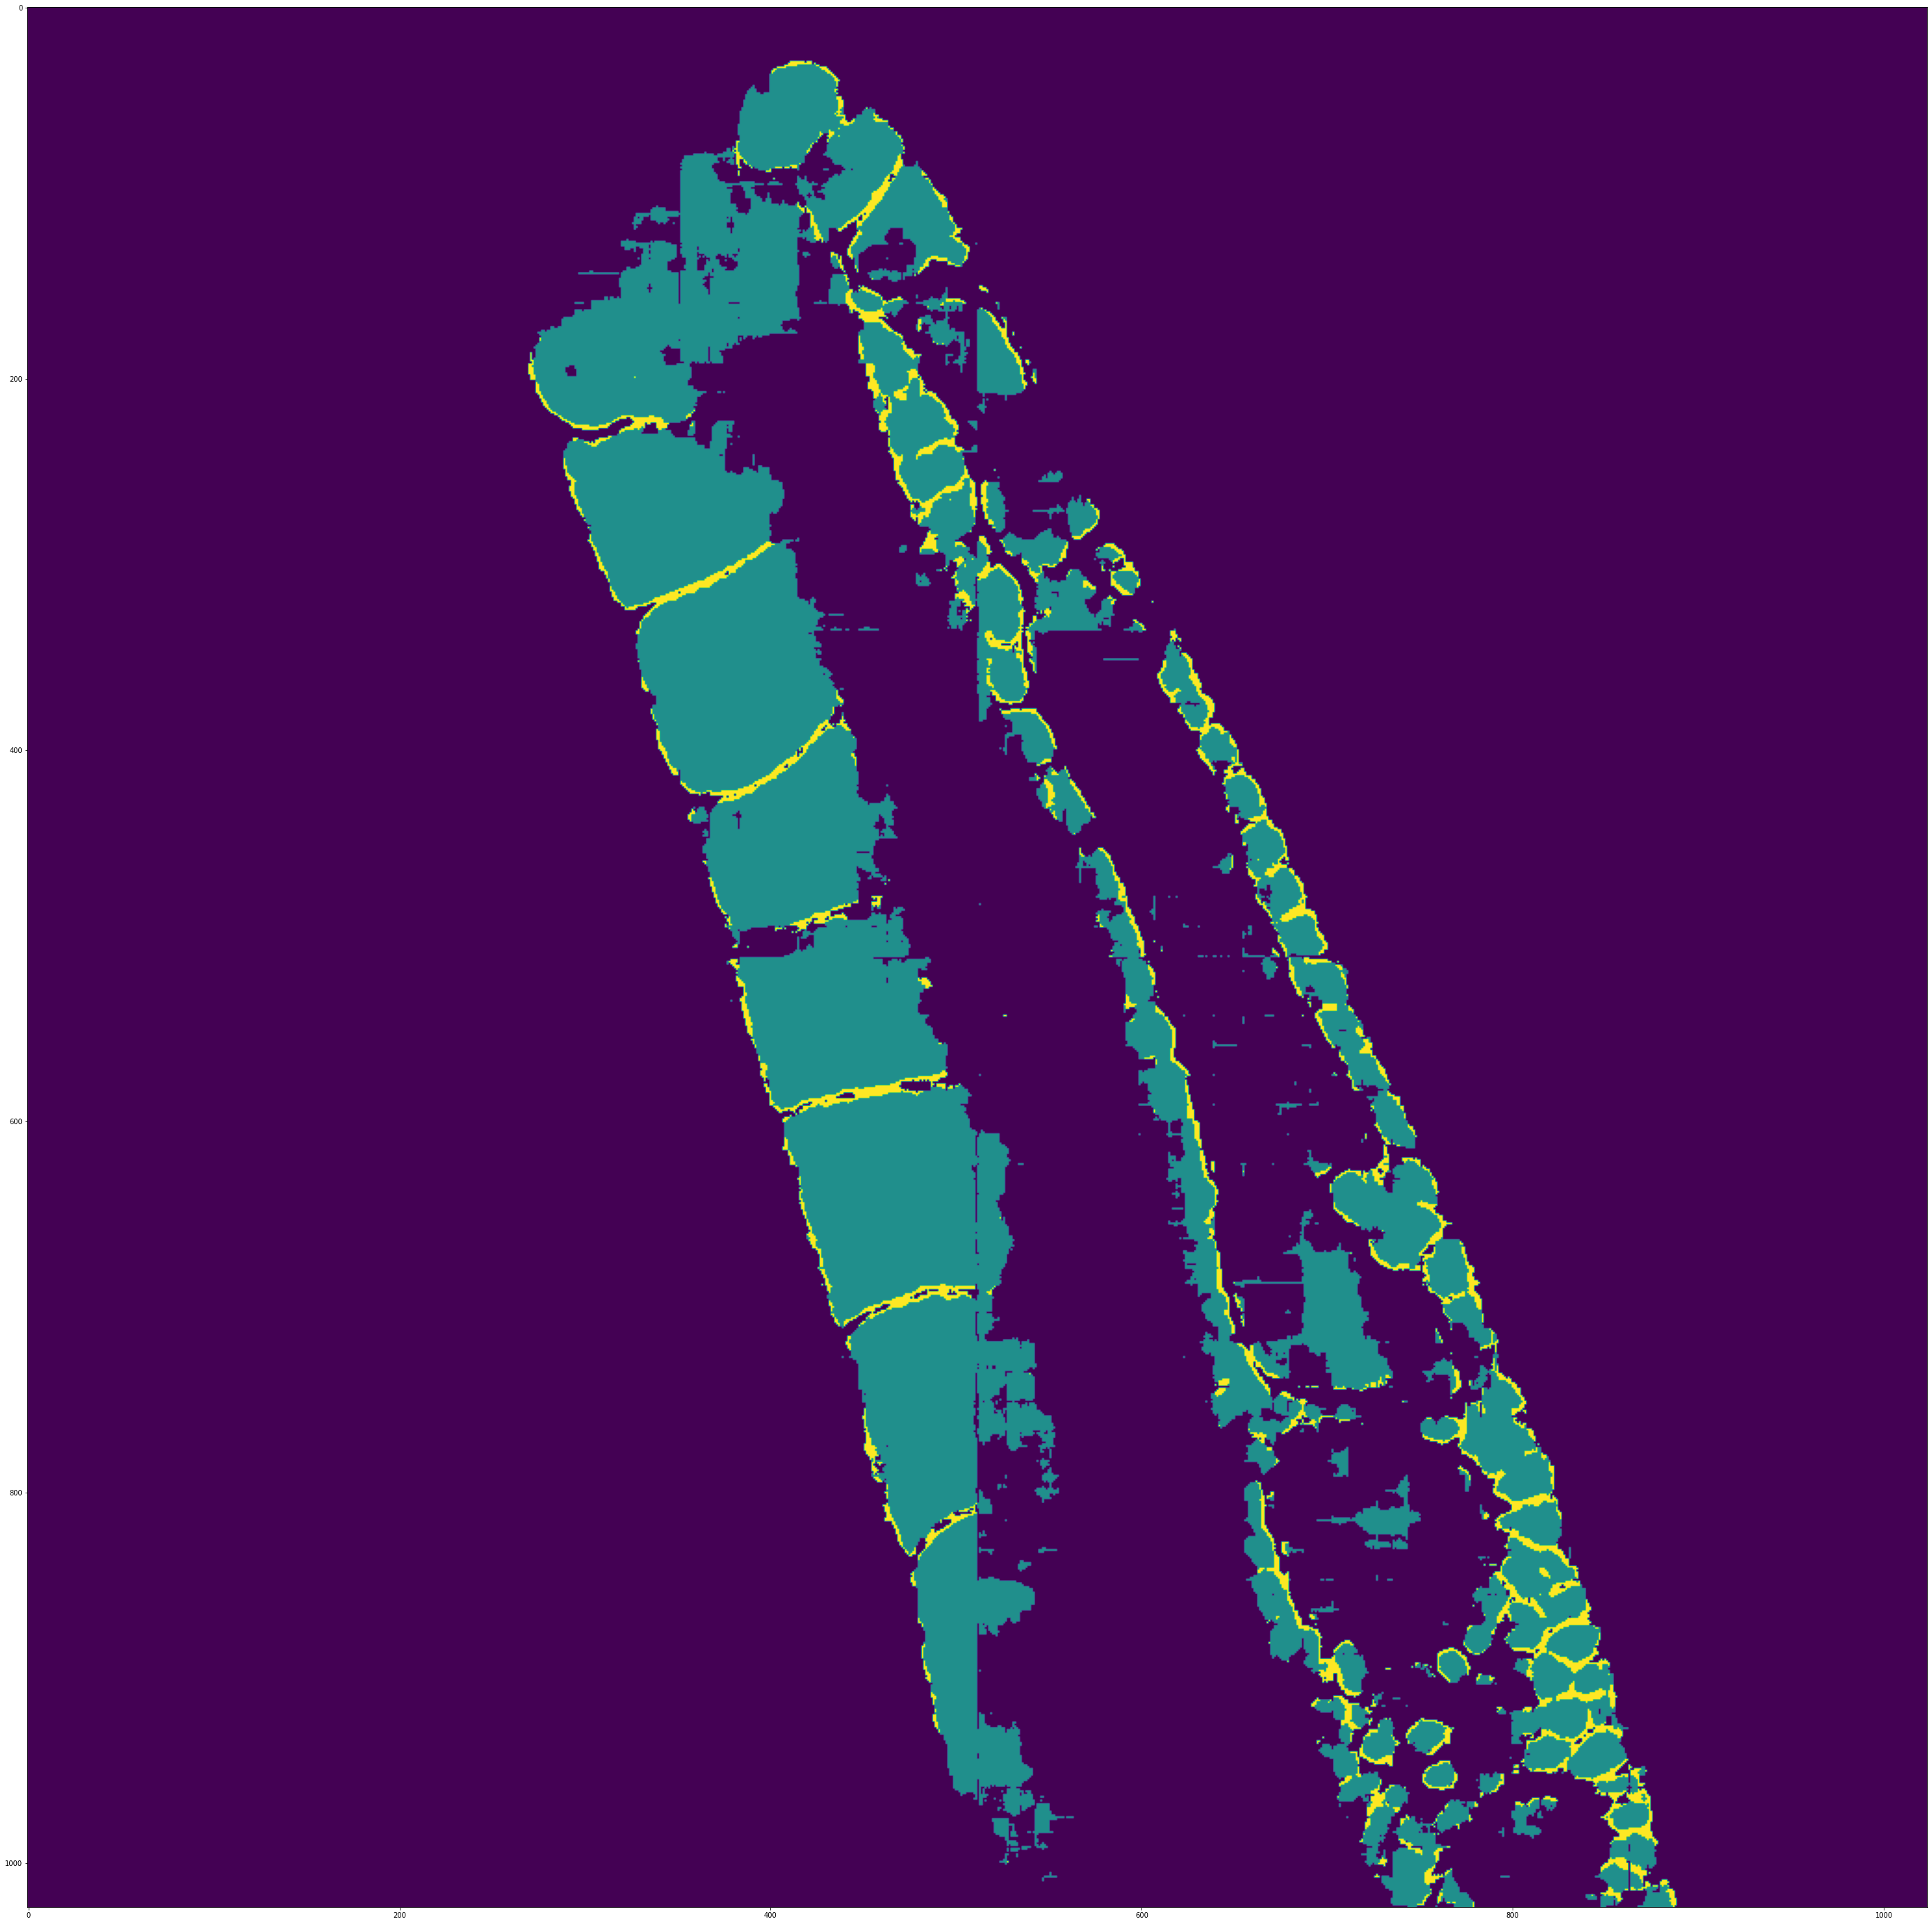

In [ ]:
plt.figure(figsize=(50,50))
plt.imshow(full)